In [1]:
import pandas as pd
from fbprophet import Prophet

In [2]:
df = pd.read_csv('/home/kkumar/Workspace/FB_Prophet_Practice/data/example_wp_log_peyton_manning.csv')

In [3]:
model = Prophet()
model.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


#### Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

#### This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

#### Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [4]:
# Taking model m from Peyton_Mannig example

from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.957184,8.469257,9.430897,8.242493,2010-02-15
1,2010-02-17,8.723619,8.236877,9.208181,8.008033,2010-02-15
2,2010-02-18,8.607378,8.094095,9.092582,8.045268,2010-02-15
3,2010-02-19,8.529250,8.014551,9.013747,7.928766,2010-02-15
4,2010-02-20,8.271228,7.764038,8.753769,7.745003,2010-02-15


#### The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [5]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
3297,37 days,0.481970,0.694241,0.502930,0.058371,0.675879
35,37 days,0.480991,0.693535,0.502007,0.058262,0.678392
2207,37 days,0.480936,0.693496,0.501928,0.058257,0.678392
2934,37 days,0.481455,0.693870,0.502999,0.058393,0.678392
393,37 days,0.483990,0.695694,0.503418,0.058494,0.678392


#### Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

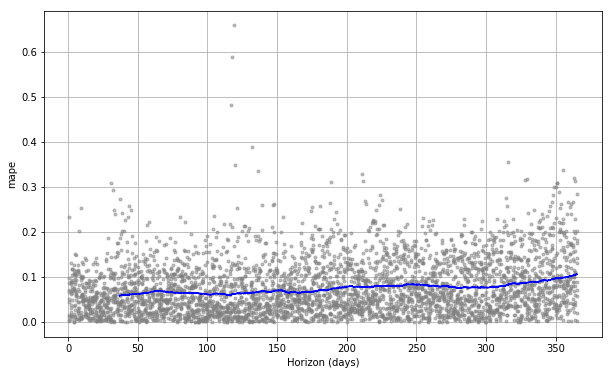

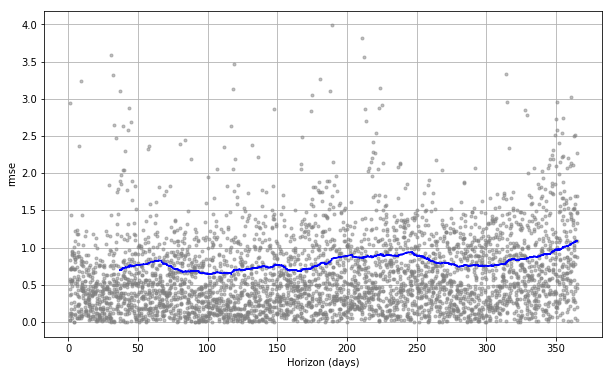

In [6]:
from fbprophet.plot import plot_cross_validation_metric
fig1 = plot_cross_validation_metric(df_cv, metric='mape')
fig2 = plot_cross_validation_metric(df_cv, metric='rmse')

#### The size of the rolling window in the figure can be changed with the optional argument rolling_window, which specifies the proportion of forecasts to use in each rolling window. The default is 0.1, corresponding to 10% of rows from df_cv included in each window; increasing this will lead to a smoother average curve in the figure.

#### The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.